# TS-LSTM Model

Reference Article- https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf

- [Requirements.txt](requirements.txt) (in same dir) lists all of the dependencies, need replicate with a new conda env
  - conda create --name `<new_env_name>` --file requirement.txt

- Originally was feeding in data like [1284, 20, 1] -- assuming [NumberSamples, Timesteps, FeaturesAtTimesteps], this however has led to some downstream errors in evaluating the model against the acutal market data, so will try to include previous 20 day values as the number of features at a SINGLE timestep = [1284, 1, 20]

- Training the model for +100 Epochs doesn't really seem to add any value to predictive accuracy, keep number of runs over data to min for testing

In [1]:
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

from StockData import * 

In [2]:
# Check if Tensorflow is a Go

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU'))) #poor

Num GPUs Available:  0


In [2]:
# Read in LSTM Specific Data -- do not even need the Label (autoencoder reproduces input sequences)
stock_data = "../Data Quality (Stocks)/Stocks_Cleaned.csv"
WINDOW_LEN = 20 #number of days to pull data for, test set size, reshape in MinMaxScaler

X_train, y_train, X_test, y_test = getData(data_path=stock_data #returns arbitrary number of samples as specified in read data file, var="n_samples"
                                          , n_days=WINDOW_LEN, column="volume", ticker="AAPL", n_samples=10_000)

X_total, y_total = getHistoricalData(data_path=stock_data, n_days=WINDOW_LEN, column="volume", ticker="AAPL", normalize=False)

Train - Data-(9980, 1, 20) Labels-(9980,)
 Test - Data-(20, 1, 20) Labels-(20,)
Hist. - Data-(1284, 1, 20) Labels-(1284,)


In [3]:
# Normalization -- MinMax Transformation (saving scalers for inverse transform)
from sklearn.preprocessing import MinMaxScaler

# Instantiate Scalers & Fit to Train Set
X_mms = MinMaxScaler()
X_mms.fit(X_train[:, 0, :])

y_mms = MinMaxScaler()
y_mms.fit(y_train.reshape(-1, 1)) #need reshape "labels" vector

# Scale Data -- Sep Scalers for X & y Sets
X_train = X_mms.transform(X_train[:, 0, :])
X_train = X_train.reshape((len(X_train), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

X_test = X_mms.transform(X_test[:, 0, :])
X_test = X_test.reshape((len(X_test), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

X_total = X_mms.transform(X_total[:, 0, :])
X_total = X_total.reshape((len(X_total), 1, WINDOW_LEN))

y_train = y_mms.transform(y_train.reshape(-1, 1))
y_test = y_mms.transform(y_test.reshape(-1, 1))
y_total = y_mms.transform(y_total.reshape(-1, 1))


# Convert ndarrays to tf tensors -- tf acts up if left in np, or try to convert in Model Call
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test  = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test  = tf.convert_to_tensor(y_test, dtype=tf.float32)
X_total = tf.convert_to_tensor(X_total, dtype=tf.float32)
y_total = tf.convert_to_tensor(y_total, dtype=tf.float32)



2022-03-16 07:29:52.449768: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-16 07:29:52.450063: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


#### Transform & Inverse-Transform Testing

In [ ]:
# Test Scaling and Unscaling
from sklearn.preprocessing import MinMaxScaler

# Instantiate Scalers & Fit to Train Set
X_mms = MinMaxScaler()
X_mms.fit(X_train[:, 0, :])

y_mms = MinMaxScaler()
y_mms.fit(y_train.reshape(-1, 1)) #need reshape "labels" vector


# Scale Data -- Sep Scalers for X & y Sets
x_scaled = X_mms.transform(X_train[:, 0, :])
x_scaled = x_scaled.reshape((len(x_scaled), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

xt = X_total.reshape((len(X_total), 1, WINDOW_LEN)) 
xt = X_mms.transform(xt[:, 0, :])
xt = xt.reshape((len(xt), 1, WINDOW_LEN))

y_scaled = y_mms.transform(y_train.reshape(-1, 1))


print(X_train[0])
print(x_scaled[0])
print("XT-->", xt[0])
print("XT-->", X_total[0])

# Undo Scaling -- works!
x_scaled = X_mms.inverse_transform(x_scaled[:, 0, :])
x_scaled = x_scaled.astype(int)
print(x_scaled[0])

xt = X_mms.inverse_transform(xt[:, 0, :])
xt = xt.astype(int)
print("XT-->", xt[0])


In [ ]:
# Example of Inverse Transform Call -- on Train Set

# Scale Data -- Sep Scalers for X & y Sets
x_scaled = X_mms.transform(X_train[:, 0, :])
x_scaled = x_scaled.reshape((len(x_scaled), 1, WINDOW_LEN)) #cheeky reshape, dims for LSTM input

print("Raw Data:", X_train[0])
print("Transformed:", x_scaled[0])

# Unscale
x_scaled = X_mms.inverse_transform(x_scaled[:, 0, :])
x_scaled = x_scaled.astype(int)
print("Inversed:", x_scaled[0])


## Def LSTM

- Currently Output Set to = **20**
  -  (change with shape [1] or [2] in output layer for either scalar or sequence output)

In [89]:
# Define LSTM Architecture

def TS_LSTM(X):

    # Convert X To Tensorflow Tensor
    X = tf.convert_to_tensor(X, dtype=tf.float32)

    # Model Layers
    lstm_large = 80
    lstm_small = 3
    inputs = layers.Input(shape=(X.shape[1], X.shape[2]), name="InputLayer") #[Timesteps X Num_Features]
    L1     = layers.LSTM(lstm_large, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.00), name="LSTM-L1")(inputs)
    L2     = layers.LSTM(lstm_small, activation='relu', return_sequences=False, name="LSTM-L2")(L1)
    L3     = layers.RepeatVector(X.shape[1], name="RepeatVector-L3")(L2)
    L4     = layers.LSTM(lstm_small, activation='relu', return_sequences=True, name="LSTM-L4")(L3)
    L5     = layers.LSTM(lstm_large, activation='relu', return_sequences=True, name="LSTM-L5")(L4)
    output = layers.TimeDistributed(layers.Dense(X.shape[2]), name="TimeDistributed-L6")(L5) #change shape to [1] for scalar outs, [2] for 20 sequence outs
    model  = Model(inputs=inputs, outputs=output)
    return model


# Instantiate Model Object & Compile 

model = TS_LSTM(X_train)
# model = TS_LSTM(X_total)
model.compile(optimizer="adam", loss="mae")
model.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 1, 20)]           0         
_________________________________________________________________
LSTM-L1 (LSTM)               (None, 1, 80)             32320     
_________________________________________________________________
LSTM-L2 (LSTM)               (None, 3)                 1008      
_________________________________________________________________
RepeatVector-L3 (RepeatVecto (None, 1, 3)              0         
_________________________________________________________________
LSTM-L4 (LSTM)               (None, 1, 3)              84        
_________________________________________________________________
LSTM-L5 (LSTM)               (None, 1, 80)             26880     
_________________________________________________________________
TimeDistributed-L6 (TimeDist (None, 1, 20)             162

In [90]:
# fit the model to the data - Scaled Data
n_epochs = 10
batch_size = 500

history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.1).history #train on Random Sampled Data
#history = model.fit(X_total, y_total, epochs=n_epochs, batch_size=batch_size, validation_split=0.01).history #train on the historical sequence

# Save the Current Iteration of the Model
model.save(f'./models/TS-LSTM.h5')


Train on 8982 samples, validate on 998 samples
Epoch 1/10
8982/8982 [==============================] - 12s 1ms/sample - loss: 0.1833 - val_loss: 0.1689
Epoch 2/10
8982/8982 [==============================] - 2s 238us/sample - loss: 0.1574 - val_loss: 0.1388
Epoch 3/10
8982/8982 [==============================] - 2s 247us/sample - loss: 0.1248 - val_loss: 0.1067
Epoch 4/10
8982/8982 [==============================] - 2s 254us/sample - loss: 0.0996 - val_loss: 0.0933
Epoch 5/10
8982/8982 [==============================] - 2s 240us/sample - loss: 0.0916 - val_loss: 0.0914
Epoch 6/10
8982/8982 [==============================] - 2s 246us/sample - loss: 0.0906 - val_loss: 0.0914
Epoch 7/10
8982/8982 [==============================] - 2s 256us/sample - loss: 0.0904 - val_loss: 0.0913
Epoch 8/10
8982/8982 [==============================] - 2s 275us/sample - loss: 0.0904 - val_loss: 0.0912
Epoch 9/10
8982/8982 [==============================] - 2s 263us/sample - loss: 0.0904 - val_loss: 0.0912


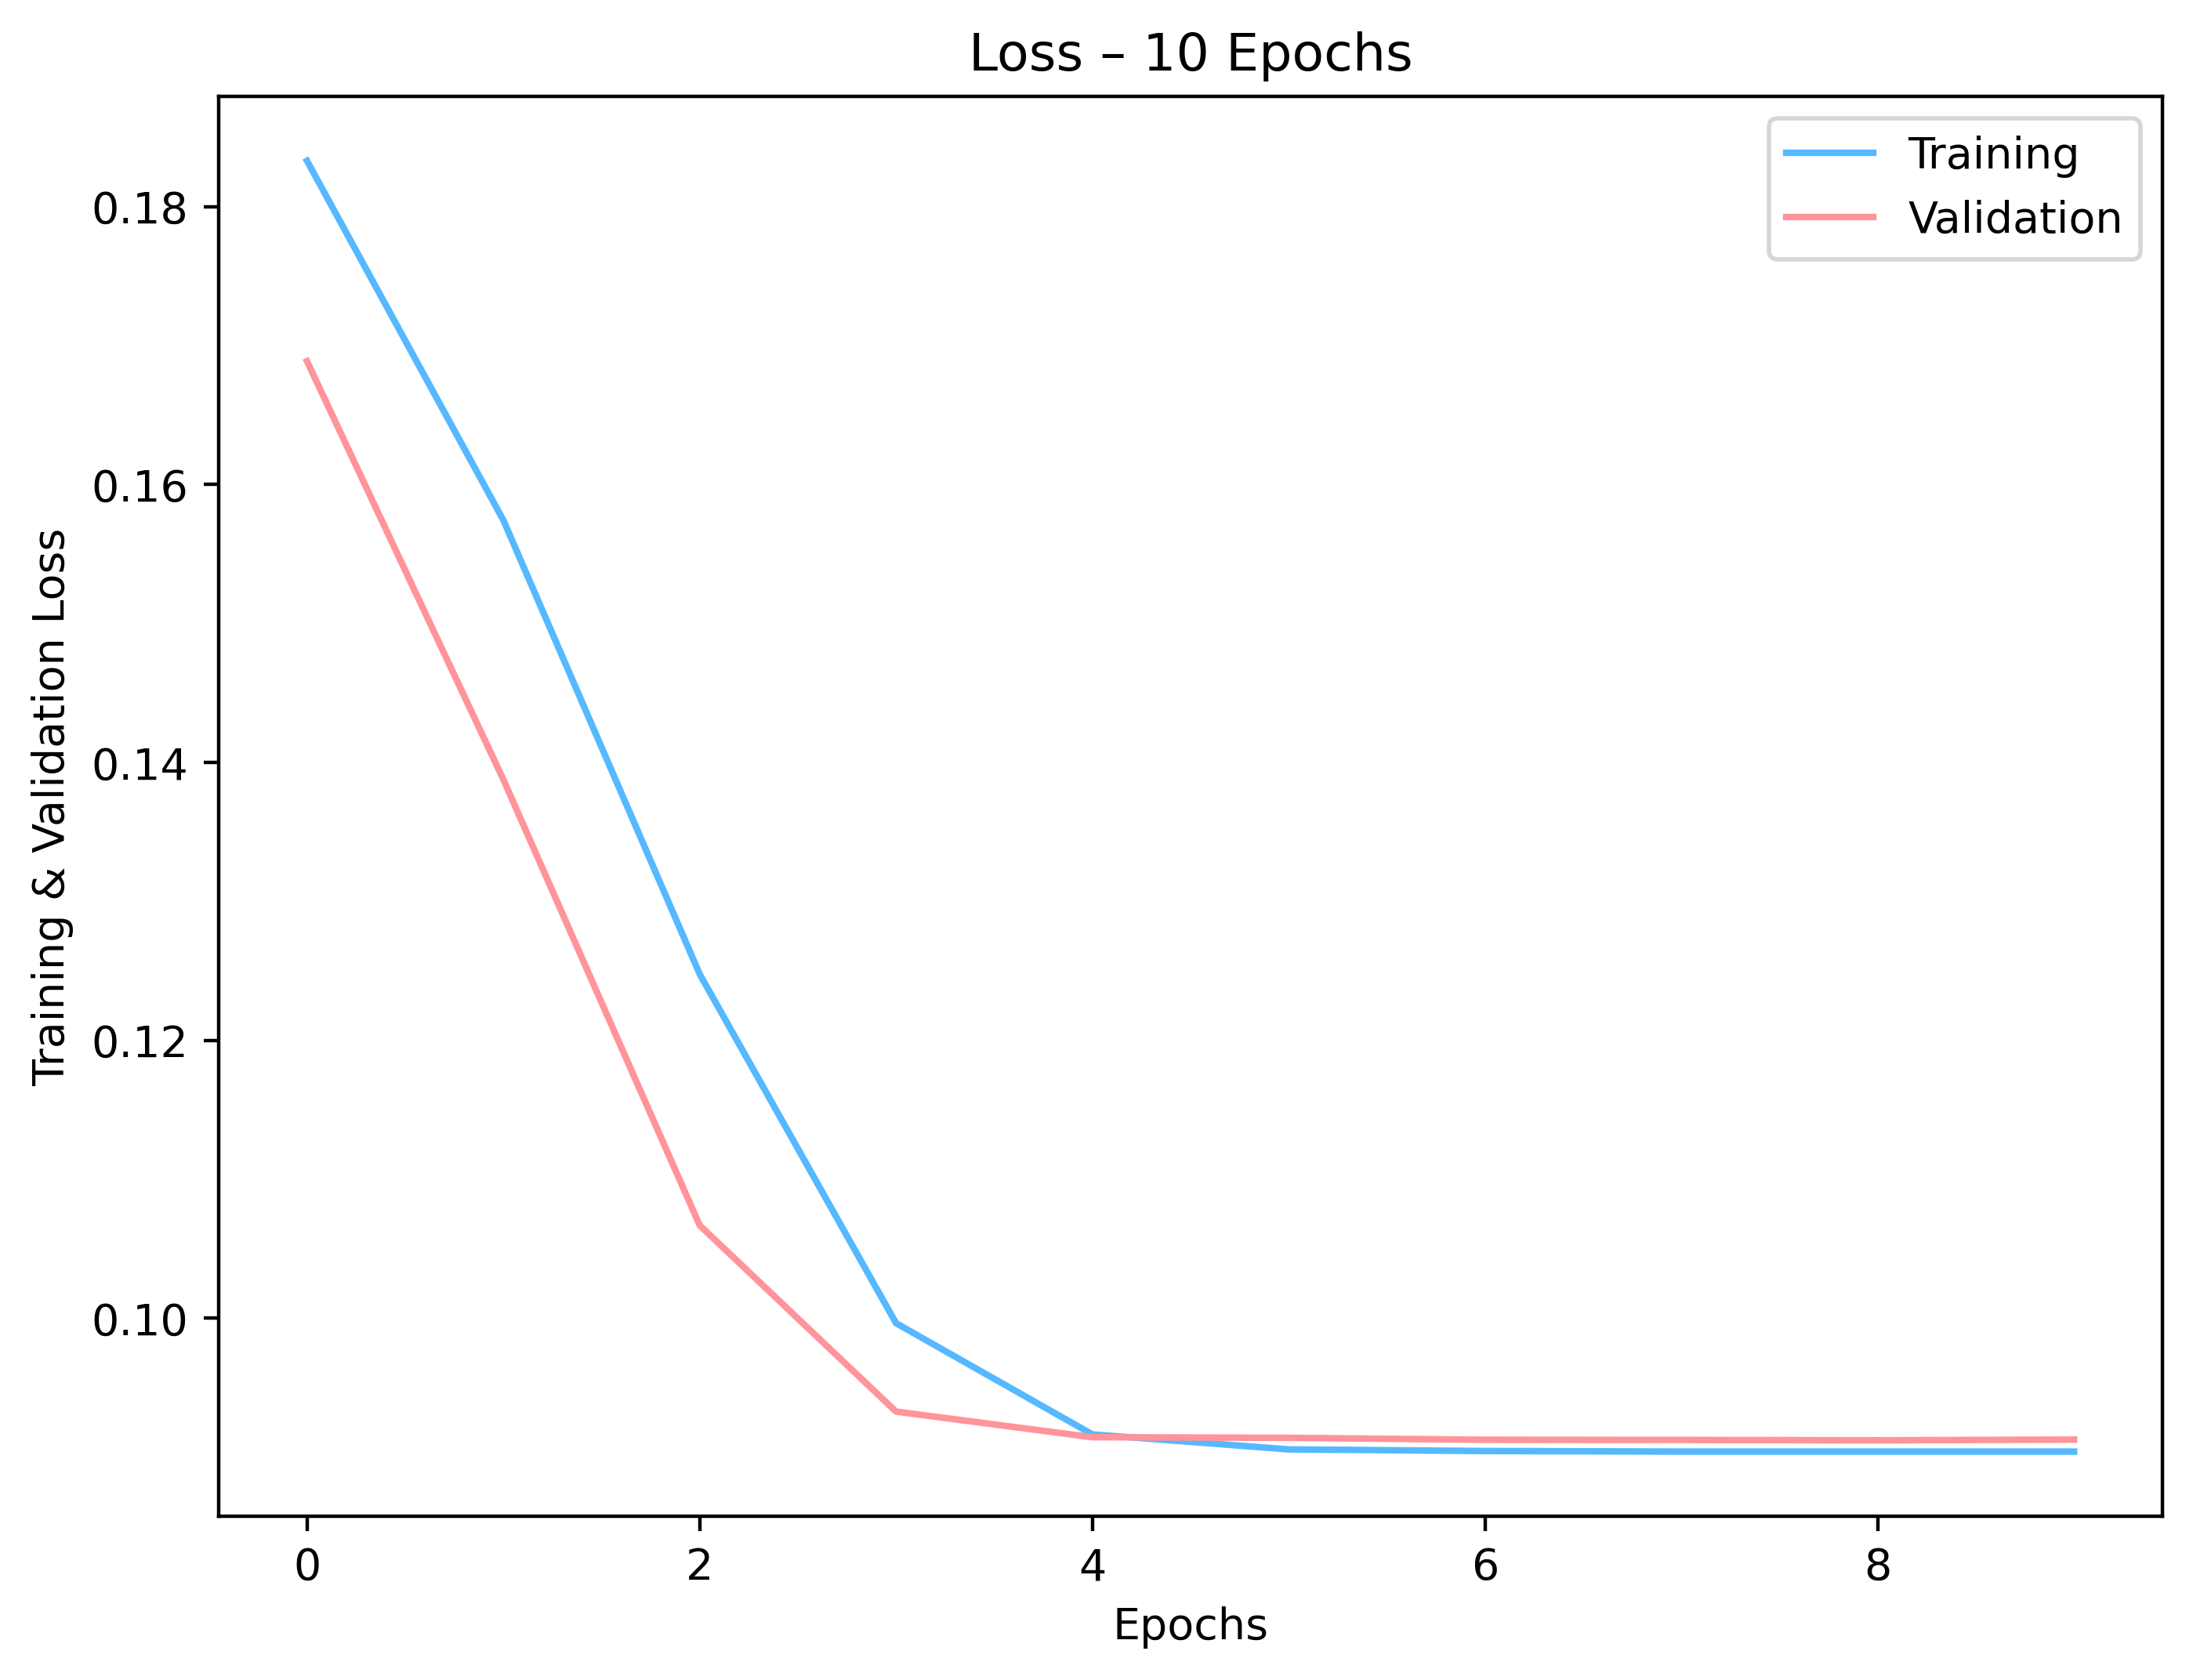

In [91]:
# Plot History from Model Training -- Accuracy
import matplotlib.pyplot as plt 

plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(8, 6), dpi=400)
plt.title(f"Training Loss – {n_epochs} Epochs")
plt.xlabel("Epochs")
plt.ylabel("Training & Validation Loss")

plt.plot(range(n_epochs), history["loss"],     color="#56B9FF", label="Training")
plt.plot(range(n_epochs), history["val_loss"], color="#FF949A", label="Validation")
plt.legend(loc="best")

In [ ]:
# Use TS-LSTM to RePredict the Whole Market Data -- Scalar Output
import matplotlib.pyplot as plt
import numpy as np

# Use model to Predict full sequence
y_pred = model.predict(X_total) #returns np.ndarray


# Reshape Arrays
y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[2]) #drop 2nd Dimension, no values
y_pred = y_pred.reshape(-1, 1)
yt = y_total.numpy()
yt = yt.reshape(-1, 1)


# Calculate Error -- Showcase in Plot
mse = (np.sum(y_total - y_pred)**2)/len(y_pred)
mse = float(mse)

rmse = np.sqrt(mse)
rmse = float(rmse)

mae = float((np.sum(np.absolute(y_total - y_pred)))/len(y_pred))


# Apply Inverse Transforms (on preds & actual array)
y_pred = y_mms.inverse_transform(y_pred) #both are scaled?
y_pred = y_pred.astype(int)

yt = y_mms.inverse_transform(yt) #both are scaled?
yt = yt.astype(int)


# Plot Market Data Vs. Predicted Movements
plt.style.use('seaborn-pastel') # "seaborn-pastel" or "dark_background"
plt.figure(figsize=(12, 8), dpi=400)
plt.title(f"AAPL - Recreation of Original Signal\nErrors– MSE: {100 * mse:.2f}% | RMSE: {100 * rmse:.2f}% | MAE: {100 * mae:.2f}%")
plt.xlabel("Trading Days")
plt.ylabel("Volume")

# plt.plot(range(X_total.shape[0]), y_total, color="#56B9FF", label="Original") #first variation, can del
plt.plot(range(X_total.shape[0]), yt, color="#56B9FF", label="Original")
plt.plot(range(X_total.shape[0]), y_pred,  color="#FF949A", label="TS-LSTM")
plt.legend(loc="best")

In [24]:
X_total.numpy().reshape(1284, 20)

array([[0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       ...,
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045],
       [0.04001912, 0.05339875, 0.12018881, ..., 0.03465457, 0.02613928,
        0.01336045]], dtype=float32)

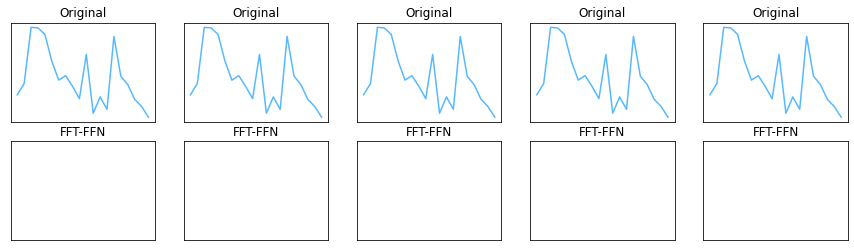

In [96]:
y_pred = model.predict(X_total) #returns np.ndarray

n = 5
plt.figure(figsize=(15, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.plot(X_total.numpy().reshape(1284, 20)[i], color="#56B9FF")
    plt.title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.plot(y_pred[i],  color="#FF949A")
    plt.title("FFT-FFN")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Plot Loss Distribution - Preds against Actuals
import seaborn as sns 

test_pred = model.predict(X_test)
print(test_pred.shape)
test_pred = test_pred.reshape(test_pred.shape[0], test_pred.shape[2])
print(test_pred.shape, y_test.shape)

pred_scores = np.mean(np.abs(test_pred-y_test), axis=1) #calculate difference

# Plotting
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution - Average Absolute Difference', fontsize=16)
sns.distplot(pred_scores, bins=20, kde=True, color='#9994FF');
plt.xlim([0.0,.5])

## Test Misc Functions

In [ ]:
# Save & Load w HDF5 Format -- tossing an error currently, H5 package is too new?
model.save(r'./models/TS-LSTM.h5')

# Read Back in and print Model Schema
m2 = tf.keras.models.load_model('./models/TS-LSTM.h5')
m2.summary()

In [39]:
# Check for Inverse Scaling of Data -- add a return of scaler object (in data read-in) ?

scaler.inverse_transform(y_test)

NameError: name 'scaler' is not defined

In [27]:
history #dict 

{'loss': [0.07760123163461685,
  0.07728737592697144,
  0.07673854380846024,
  0.07617157697677612,
  0.07559974491596222,
  0.07570918649435043,
  0.07473623007535934,
  0.07475299388170242,
  0.07404287159442902,
  0.07454744726419449],
 'val_loss': [0.06179007142782211,
  0.062257975339889526,
  0.061781249940395355,
  0.06358292698860168,
  0.06012799218297005,
  0.06356558948755264,
  0.06544844806194305,
  0.06244674324989319,
  0.06370559334754944,
  0.05944409221410751]}

In [15]:
# fit the model to the data -- Unscaled Test
n_epochs = 3
batch_size = 20
history = model.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/3
48/48 [==============================] - 5s 42ms/step - loss: 59327576.0000 - val_loss: 34600088.0000
Epoch 2/3
48/48 [==============================] - 1s 22ms/step - loss: 59327480.0000 - val_loss: 34598384.0000
Epoch 3/3
48/48 [==============================] - 1s 20ms/step - loss: 58069644.0000 - val_loss: 32728922.0000
